In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.legend_handler import HandlerTuple
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
# Function definitions
def generate_uniform_points(n):
    return np.random.rand(n, 2)


def generate_corner_points(n, a=0.05):
    corners = np.array([[a, a], [a, 1 - a], [1 - a, 0], [1 - a, 1 - a]])
    n_corner = n // 4
    corner_points = np.zeros((4 * n_corner, 2))

    for i in range(4):
        corner_points[i * n_corner : (i + 1) * n_corner] = corners[i] + np.random.uniform(-a, a, (n_corner, 2))
    return corner_points


def generate_center_points(n, a=0.05):
    return np.random.uniform(0.5 - a, 0.5 + a, (n, 2))


def avg_pairwise_distance(X):
    return pairwise_distances(X).sum() / (X.shape[0] * (X.shape[0] - 1))


def sphere_exclusion(points, r):
    # get the pairwise distances and create a boolean matrix
    connectivity_matrix = (pairwise_distances(points) < r).astype(int)
    # subtract the identity matrix to remove self-connections
    connectivity_matrix = connectivity_matrix - np.eye(connectivity_matrix.shape[0])
    G = nx.from_numpy_array(connectivity_matrix)

    neighbour_dict = nx.to_dict_of_lists(G)

    forbidden_nodes = set()
    selected_nodes = set()
    selected_nodes_list = []
    forbidden_nodes_lists = []
    for node, neighbours in neighbour_dict.items():
        if node in forbidden_nodes:
            continue
        selected_nodes.add(node)
        selected_nodes_list.append(node)
        just_forbidden = list((set(neighbours) - selected_nodes) - forbidden_nodes)
        forbidden_nodes.update(neighbours)
        forbidden_nodes_lists.append(just_forbidden)  # needed for plotting

    return list(selected_nodes), selected_nodes_list, forbidden_nodes_lists


def ncircles_from_points(points, r):
    return len(sphere_exclusion(points, r))

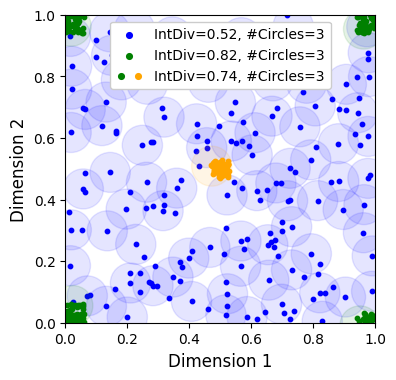

In [3]:
# Main program
np.random.seed(0)
n = 200
r = 0.065

uniform_points = generate_uniform_points(n)
corner_points = generate_corner_points(n, a=0.03)
center_points = generate_center_points(n // 4, a=0.03)
points_dict = {
    "uniform": uniform_points,
    "corner": corner_points,
    "center": center_points,
}
color_dict = {"uniform": "b", "corner": "green", "center": "orange"}

# Update the label for uniform points with the computed int_div value

fig, ax = plt.subplots(figsize=(4, 4))

rets = []
labels = []
for points_type in points_dict.keys():
    points = points_dict[points_type]

    # Add the center points to the center points for calculation
    # but keep them separate for plotting
    if points_type == "center":
        calc_points = np.vstack((corner_points, points))
    else:
        calc_points = points
    int_div = avg_pairwise_distance(calc_points)
    n_circles = ncircles_from_points(calc_points, r)
    picks_plot, _, _ = sphere_exclusion(points, r)

    label = f"IntDiv={int_div:.2f}, #Circles={n_circles}"
    labels.append(label)
    m = ax.scatter(points[:, 0], points[:, 1], s=10, c=color_dict[points_type], label=label)
    rets.append(m)

    for idx in picks_plot:
        ax.add_artist(plt.Circle(points[idx], r, color=color_dict[points_type], alpha=0.1))


ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.xlabel("Dimension 1", fontsize="large")
plt.ylabel("Dimension 2", fontsize="large")


ax.legend(
    (rets[0], rets[1], (rets[1], rets[2])),
    labels,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc="upper center",
    fontsize="medium",
    framealpha=1,
    ncol=1,
    markerscale=1.3,
)
plt.savefig("figures/intdiv_se.pdf", bbox_inches="tight")

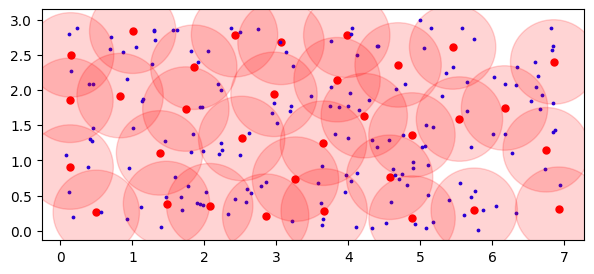

In [4]:
# sample hyperuniform points


np.random.seed(0)
points = generate_uniform_points(200)
width, height = 7, 3
scaled_points = points * [width, height]

# plot circle around points with radius 0.1
# for idx in ncircles_from_points(points, 0.1):
#     plt.gca().add_artist(plt.Circle(points[idx], 0.1, color='r', alpha=0.17))

r = 0.6

selected_idx, _, _ = sphere_exclusion(scaled_points, r)

# draw circles around selected points
plt.figure(figsize=(width, height))
# plot selected points in red
plt.scatter(scaled_points[selected_idx, 0], scaled_points[selected_idx, 1], s=25, c="r")
# and the rest in blue
plt.scatter(
    scaled_points[~np.isin(np.arange(scaled_points.shape[0]), selected_idx), 0],
    scaled_points[~np.isin(np.arange(scaled_points.shape[0]), selected_idx), 1],
    s=3,
    c="b",
)

for idx in selected_idx:
    plt.gca().add_artist(plt.Circle(scaled_points[idx], r, color="r", alpha=0.17))

33


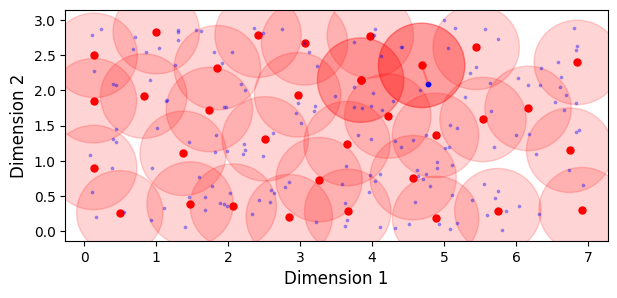

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Create a sphere exclusion animation


def create_animation(points, r, fps, width, height):
    _, selected_nodes_list, forbidden_nodes_lists = sphere_exclusion(points, r)

    print(len(selected_nodes_list))

    all_selected = []
    all_excluded_set = set()

    fig, ax = plt.subplots(figsize=(width, height))

    def update(num):
        ax.clear()
        just_selected = selected_nodes_list[num]
        just_excluded = forbidden_nodes_lists[num]

        all_selected.append(just_selected)
        # global all_excluded
        all_excluded_set.update(just_excluded)  # need extra var because of scope
        all_excluded = list(all_excluded_set)

        # plot the selected points
        ax.scatter(points[all_selected, 0], points[all_selected, 1], s=25, c="r")
        # plot sphere around selected points
        for idx in all_selected:
            ax.add_artist(plt.Circle(points[idx], r, color="r", alpha=0.17))
        # plot sphere around just selected with extra shading
        ax.add_artist(plt.Circle(points[just_selected], r, color="red", alpha=0.25))

        # plot the excluded points
        ax.scatter(points[all_excluded, 0], points[all_excluded, 1], s=3, c="blue", alpha=0.3)

        remaining_idx = [i for i in range(points.shape[0]) if i not in set(all_selected + all_excluded)]
        # plot the remaining points
        ax.scatter(points[remaining_idx, 0], points[remaining_idx, 1], s=10, c="blue")
        # plot the just forbidden points in the same style
        ax.scatter(points[just_excluded, 0], points[just_excluded, 1], s=10, c="blue")

        p_just_selected = points[just_selected]
        for excluded in just_excluded:
            p_excluded = points[excluded]
            ax.plot(
                [p_just_selected[0], p_excluded[0]],
                [p_just_selected[1], p_excluded[1]],
                c="r",
                alpha=0.3,
            )

        # ax.set_xlim(0, 1)
        # ax.set_ylim(0, 1)
        ax.set_xlabel("Dimension 1", fontsize="large")
        ax.set_ylabel("Dimension 2", fontsize="large")

    ani = FuncAnimation(fig, update, frames=len(selected_nodes_list), repeat=True)
    # Save as gif

    output_filename = f"figures/sphere_exclusion_animation_{fps:.0f}.gif"
    ani.save(output_filename, writer="imagemagick", fps=fps)


# Example usage:
# Assuming points, selected_nodes_list, forbidden_nodes_lists, and r are defined

width, height = 7, 3
scaled_points = points * [width, height]

create_animation(scaled_points, 0.6, fps=3, width=width, height=height)